In [1]:
### import packages 
from brian2 import *
from brian2.units import *
from brian2 import ms, mV, pA, pF, siemens, amp, second, NeuronGroup, defaultclock, run
from brian2tools import *
import matplotlib.pyplot as plt
import random
import numpy as np
import json

from models.AdEx import NeuronModel
from simulation_runner import run_simulation
from synapse import SynapseModel, connect
from result import Visualization

import subprocess
from IPython.display import display, Markdown
from simulation_runner import convert_units, load_params, run_simulation

### Modeling Result

Converted parameters: {'k': 1, 'v': -80. * mvolt, 'u': 0. * volt / second, 'vr': -64.4 * mvolt, 'vt': -50. * mvolt, 'a': 200. * mhertz, 'b': 25. * mhertz, 'C': 80. * pfarad, 'd': 0. * volt / second, 'I': 100. * pamp}


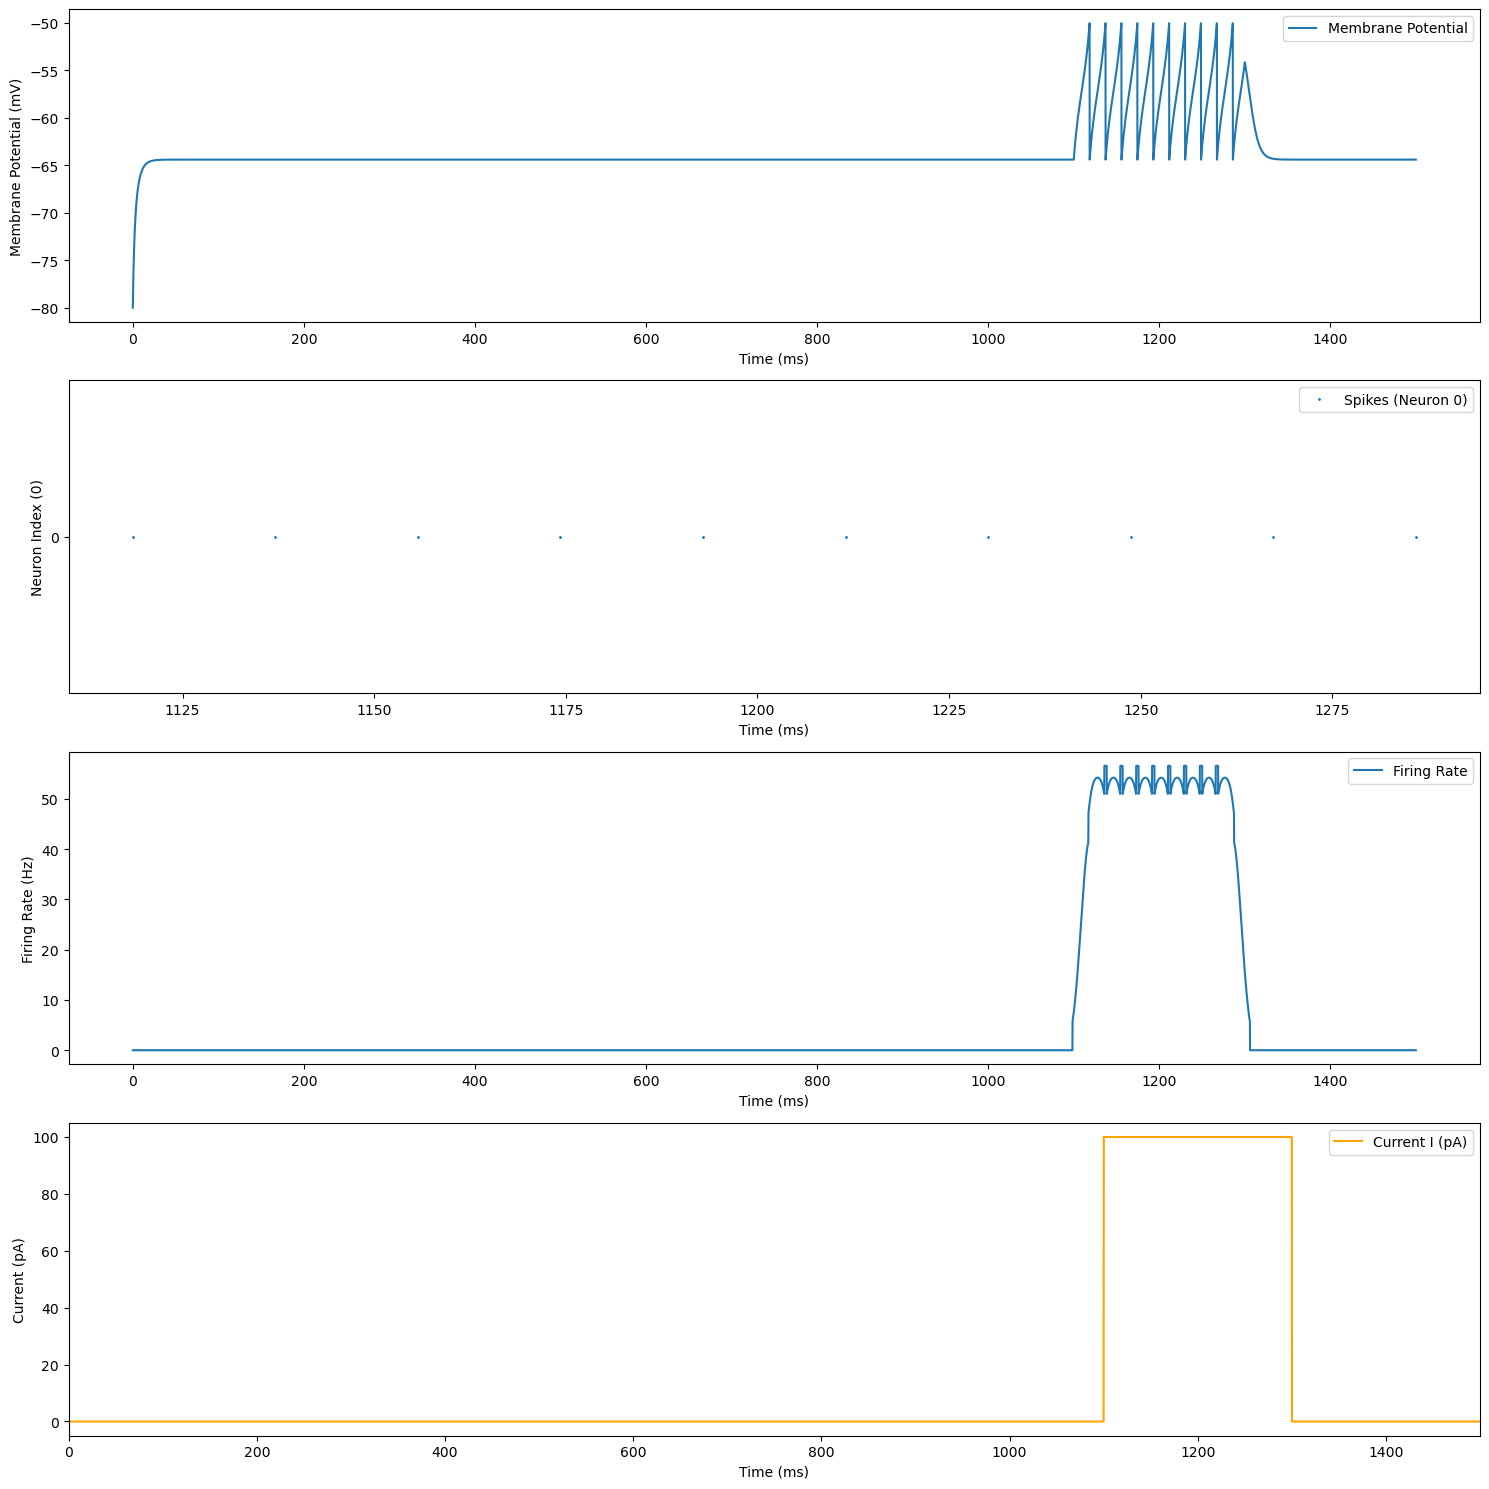

In [3]:
### Qudratic Integrate and Fire 
json_file = './params/QIF.json' 

# load parameters
params, model_name = load_params(json_file)
N = params.pop('N')['value'] 

# simulation 
sim = run_simulation(N, params, model_name)

# visualization
sim.plot_results()

Converted parameters: {'g_L': 6.46 * nsiemens, 'v': -80. * mvolt, 'vr': -85.4 * mvolt, 'vt': -45. * mvolt, 'E_L': -85.4 * mvolt, 'C': 157. * pfarad, 'I': 300. * pamp}


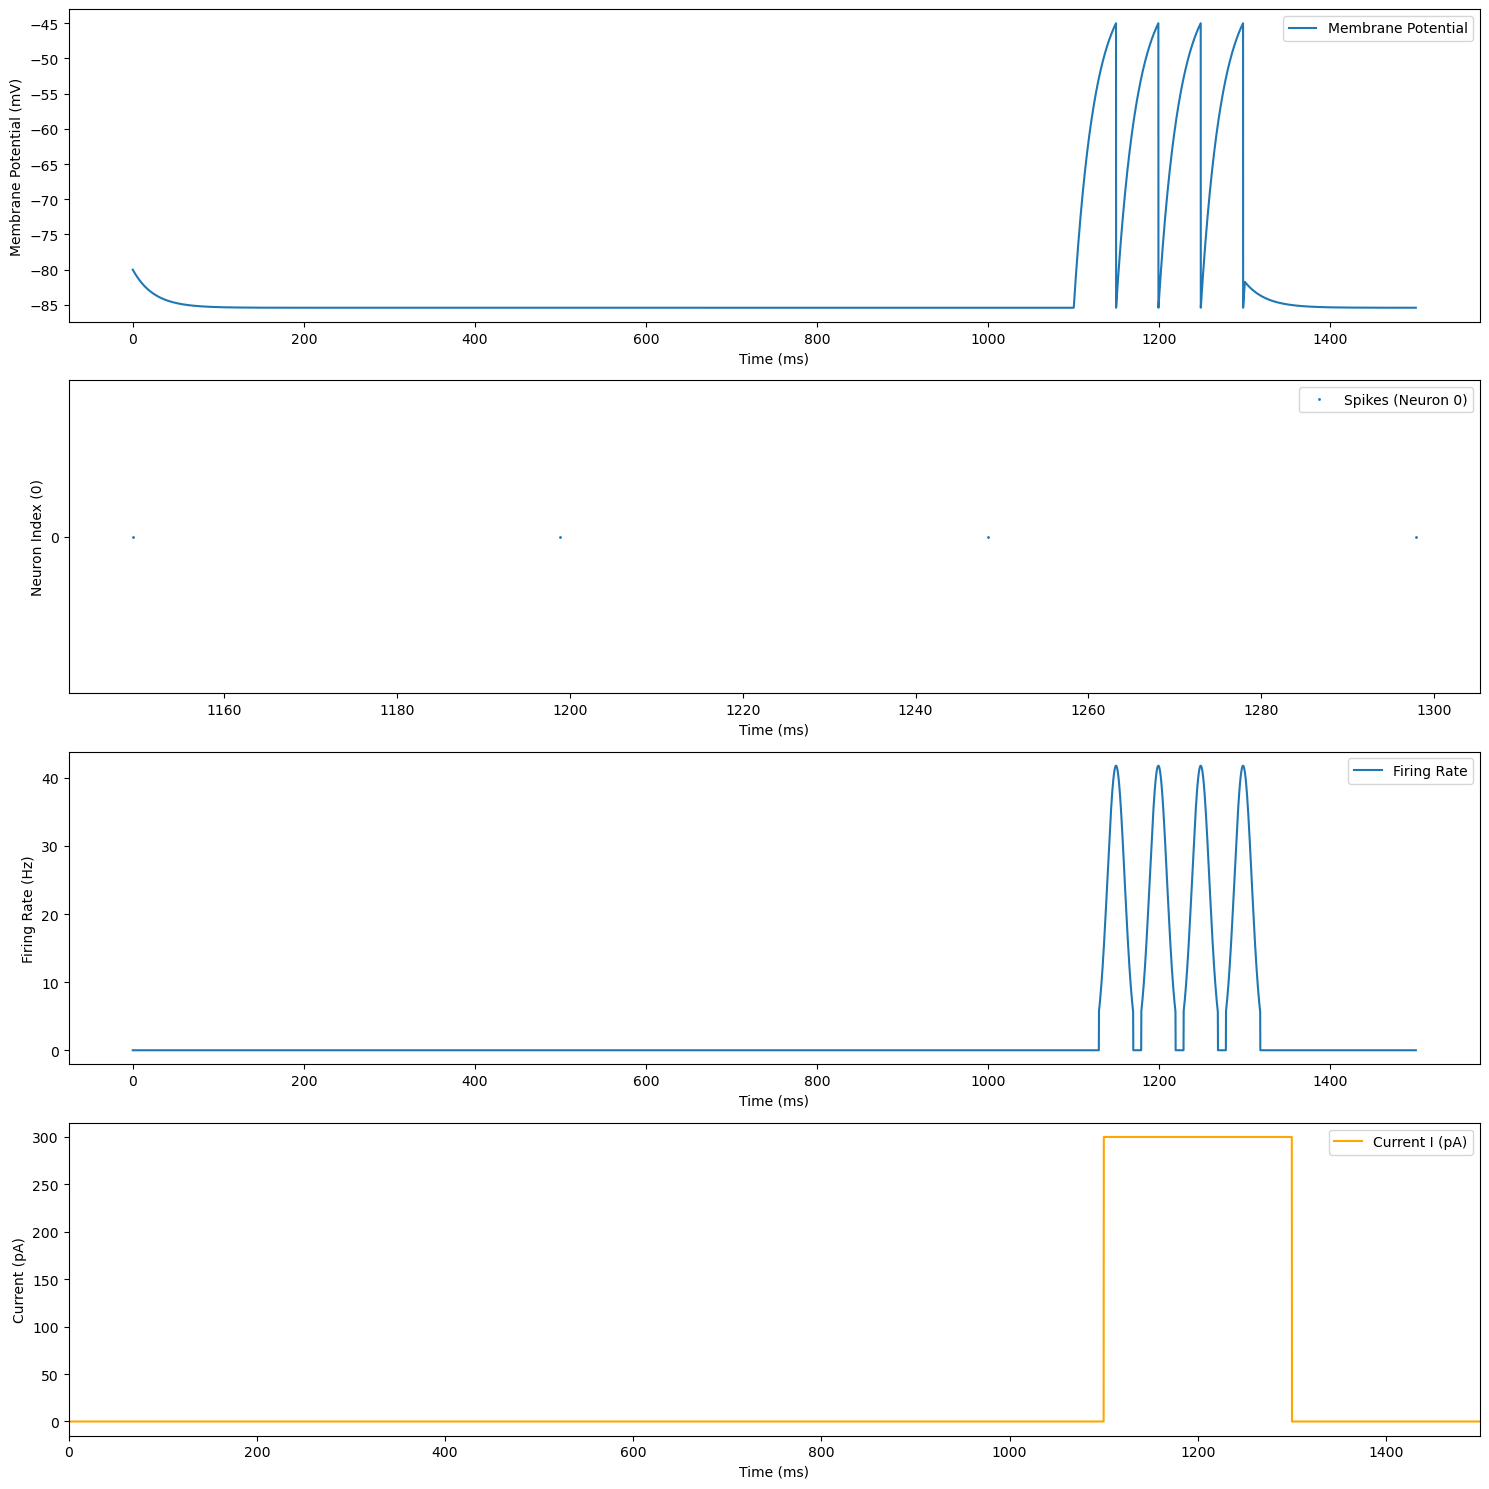

In [7]:
### Leaky Integrate and Fire 
json_file = './params/LIF.json'  # 사용할 JSON 파일 경로

# load parameters
params, model_name = load_params(json_file)
N = params.pop('N')['value']  # N은 모델의 뉴런 수

# simulation 
neuron_model_class = NeuronModel  # 예시로 NeuronModel 클래스를 사용
sim = run_simulation(N, params, model_name)

# visualization
sim.plot_results()

Converted parameters: {'g_L': 12. * nsiemens, 'E_L': -58. * mvolt, 'Delta_T': 7. * mvolt, 'vt': -58. * mvolt, 'vr': -70. * mvolt, 'tau_w': 12. * msecond, 'a': 8. * nsiemens, 'd': 3. * pamp, 'C': 115. * pfarad, 'I': 10. * pamp}


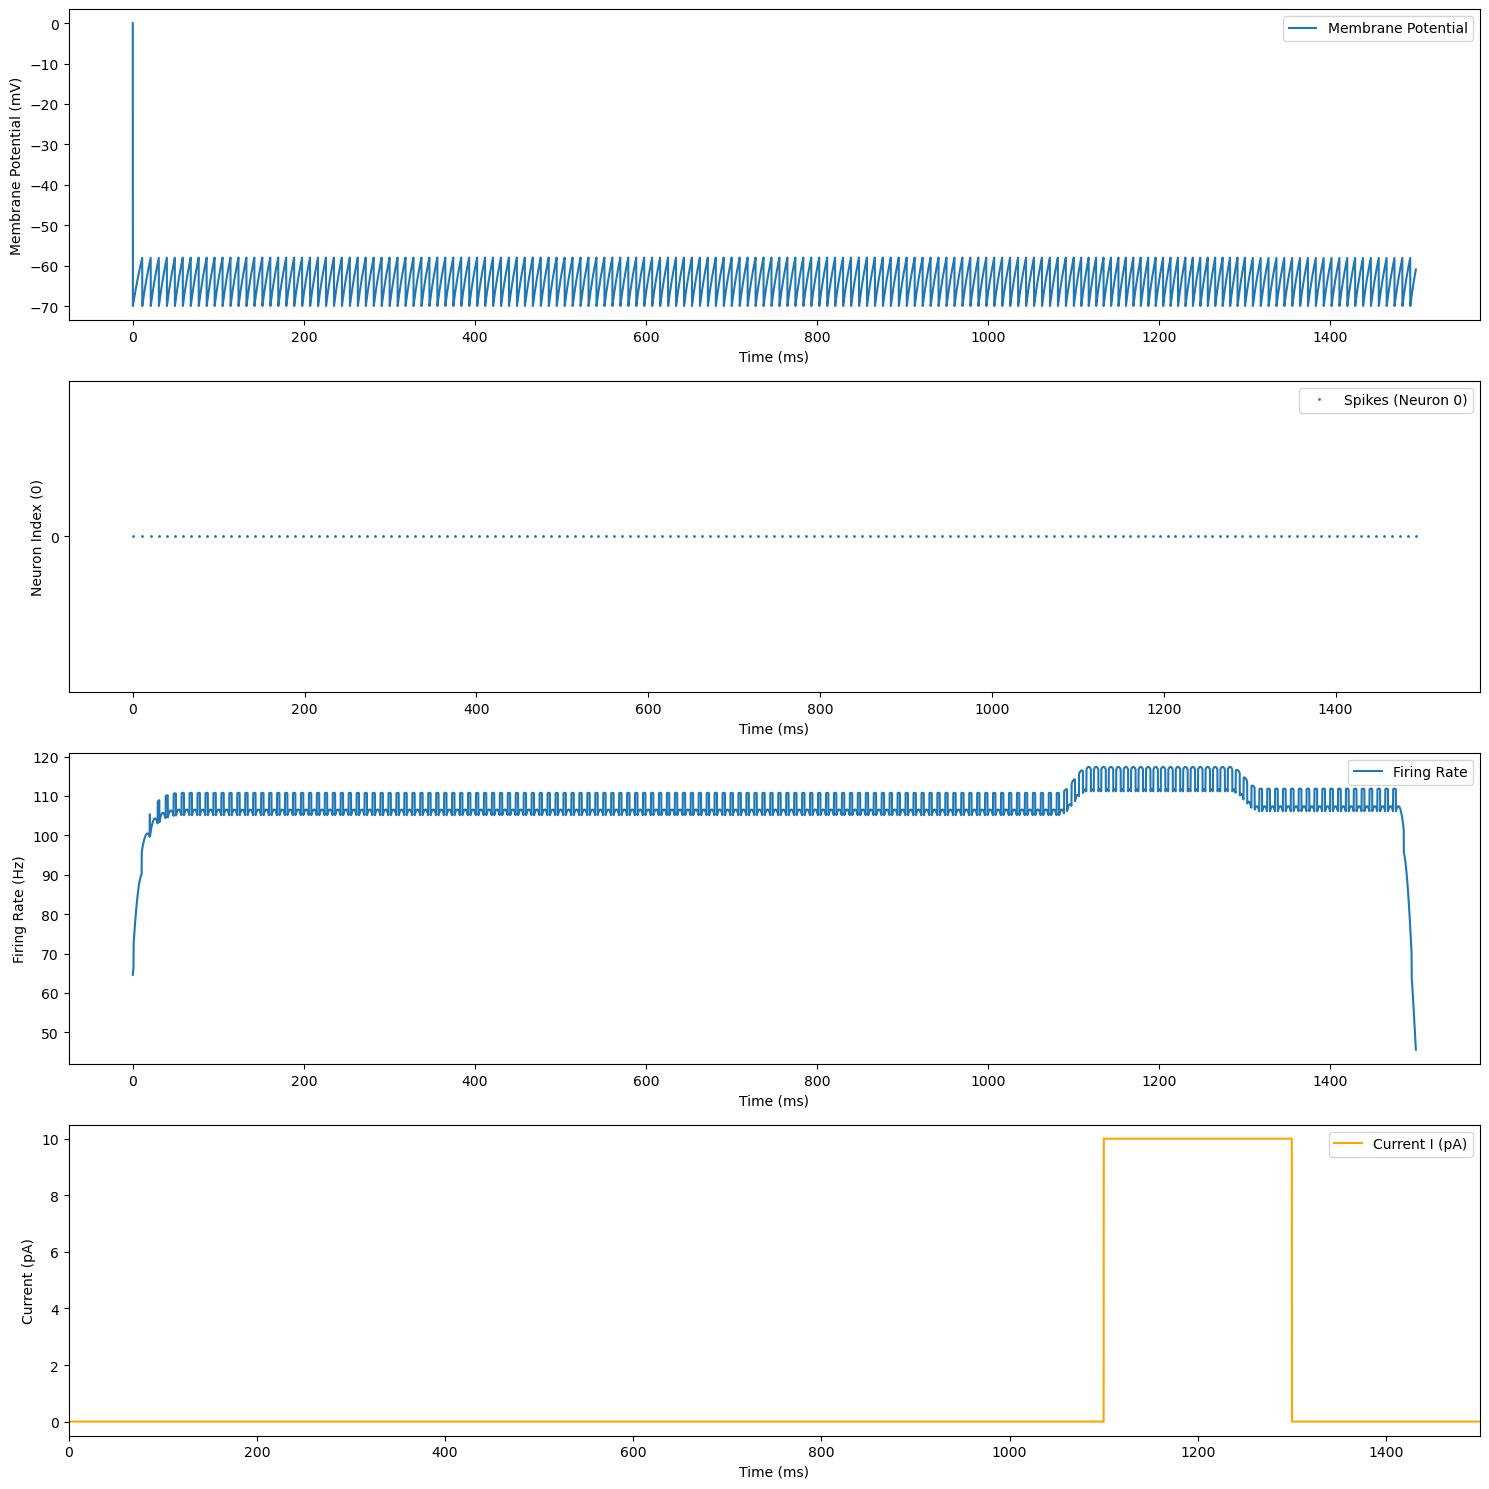

In [6]:
### Adaptive Exponential Integrate and Fire 
json_file = './params/AdEx.json'  # 사용할 JSON 파일 경로

# load parameters
params, model_name = load_params(json_file)
N = params.pop('N')['value']  

# simulation 
sim = run_simulation(N, params, model_name)

# visualization
sim.plot_results()

Converted parameters: {'v': -80. * mvolt, 'u': 0. * volt / second, 'vr': -64.4 * mvolt, 'a': 200. * mhertz, 'b': 25. * mhertz, 'd': 0. * volt / second, 'I': 1000. * volt / second}
1.e+15 V/s


INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_8xd572ct/var
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_8xd572ct/var/folders
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_8xd572ct/var/folders/tj
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_8xd572ct/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_8xd572ct/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_8xd572ct/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_8xd572ct
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch

v did not reach v_reset, stopping simulation


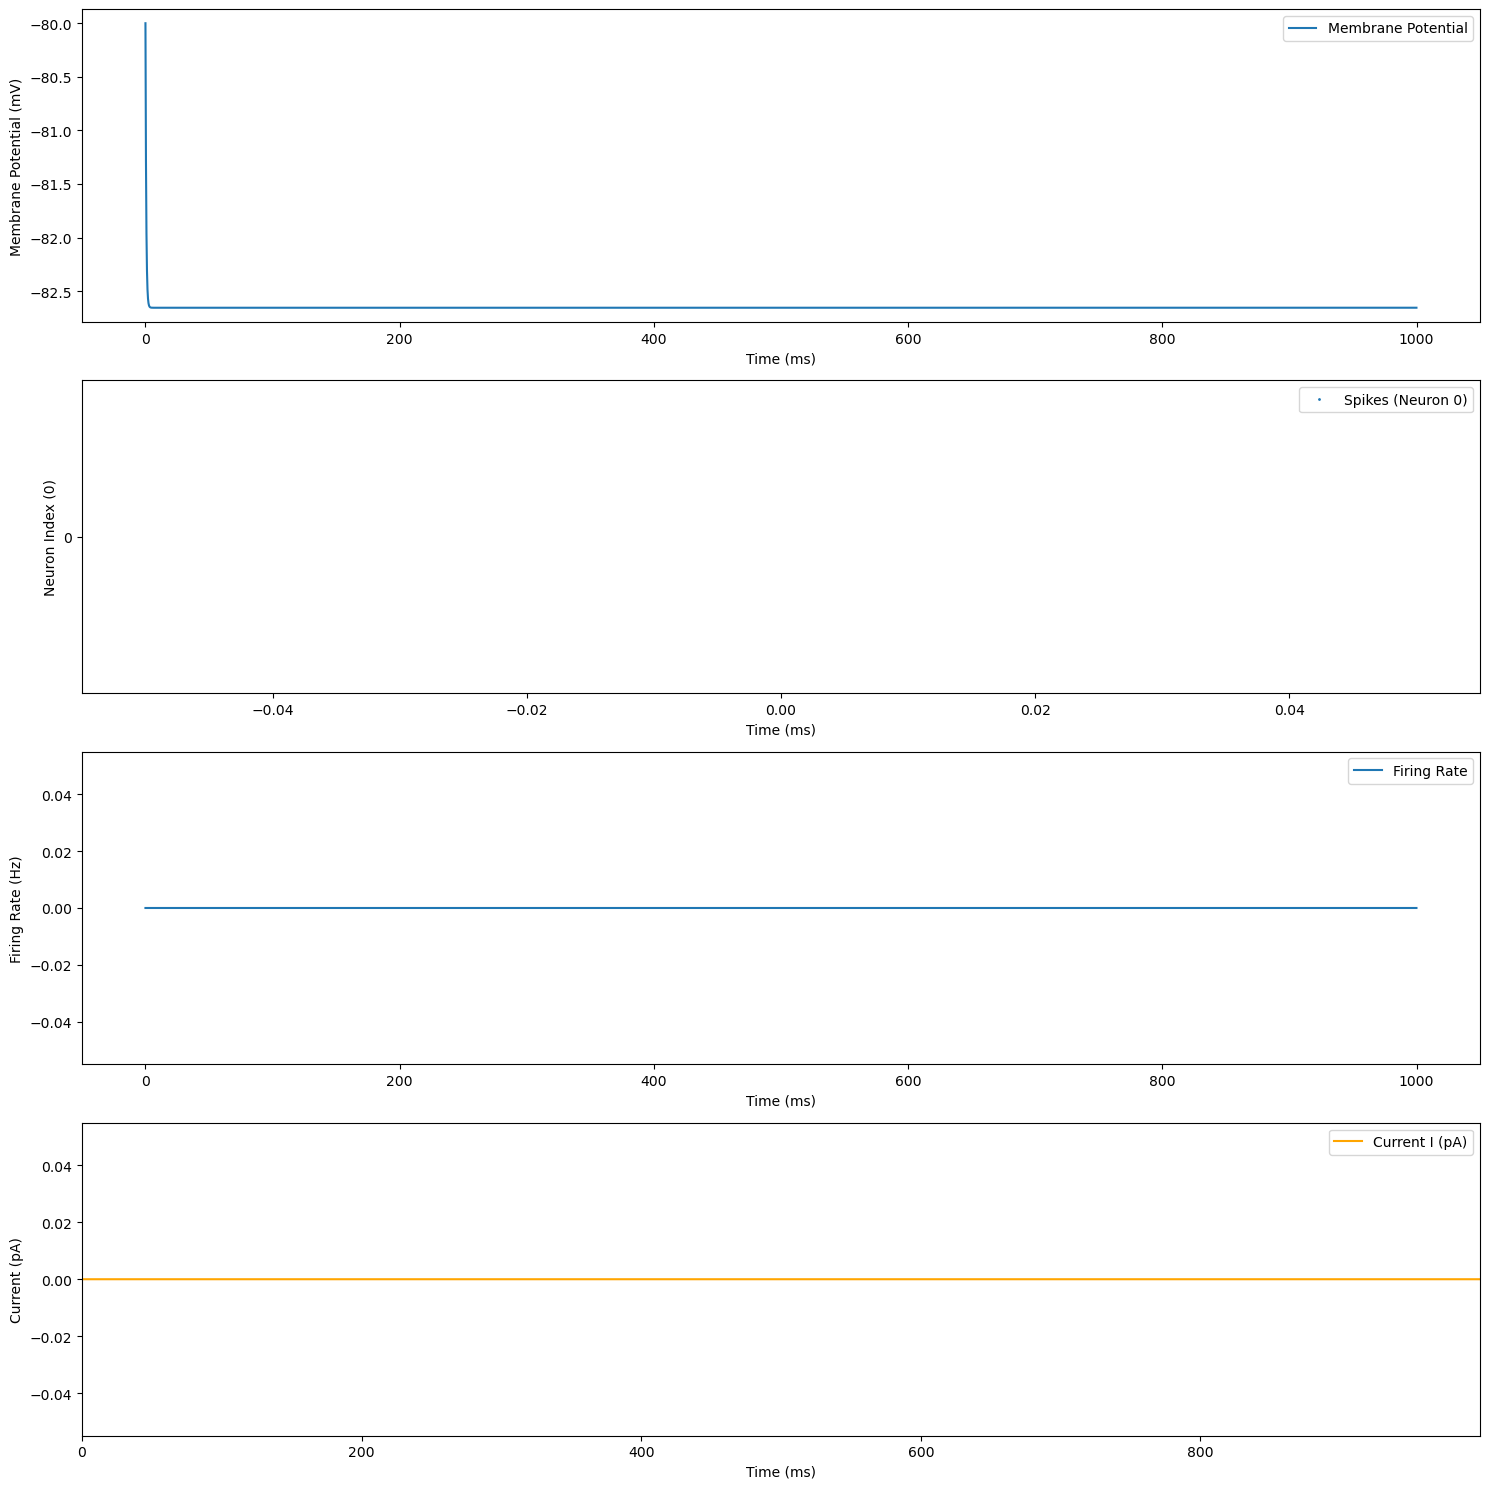

In [2]:
### Izhikevich
json_file = './params/Izh.json'  # 사용할 JSON 파일 경로

# load parameters
params, model_name = load_params(json_file)
N = params.pop('N')['value']  # N은 모델의 뉴런 수

# simulation 
neuron_model_class = NeuronModel  # 예시로 NeuronModel 클래스를 사용
sim = run_simulation(N, params, model_name)

# visualization
sim.plot_results()